In [2]:
# import system libs
import os
import itertools
from PIL import Image # pillow - for managing and manipulating different image formats

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
# Generate train data paths with labels
#train_data = 'C:/Users/DELL/Desktop/Demo1/Training/'
train_data = 'C:/Users/DELL/Desktop/Demo1/Testing/'
filepaths = []
labels = []

folds = os.listdir(train_data)

for fold in folds: 
    foldpath = os.path.join(train_data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
1,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
2,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
3,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
4,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
...,...,...
1306,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1307,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1308,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1309,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary


In [5]:
# Generate test data paths with labels
#test_data_dir = 'C:/Users/DELL/Desktop/Demo1/Training/'
test_data_dir = 'C:/Users/DELL/Desktop/Demo1/Testing/'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
ts_df

,filepaths,labels
0,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
1,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
2,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
3,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
4,C:/Users/DELL/Desktop/Demo1/Testing/glioma\Te-...,glioma
...,...,...
1306,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1307,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1308,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary
1309,C:/Users/DELL/Desktop/Demo1/Testing/pituitary\...,pituitary


In [7]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 48)

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1311 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


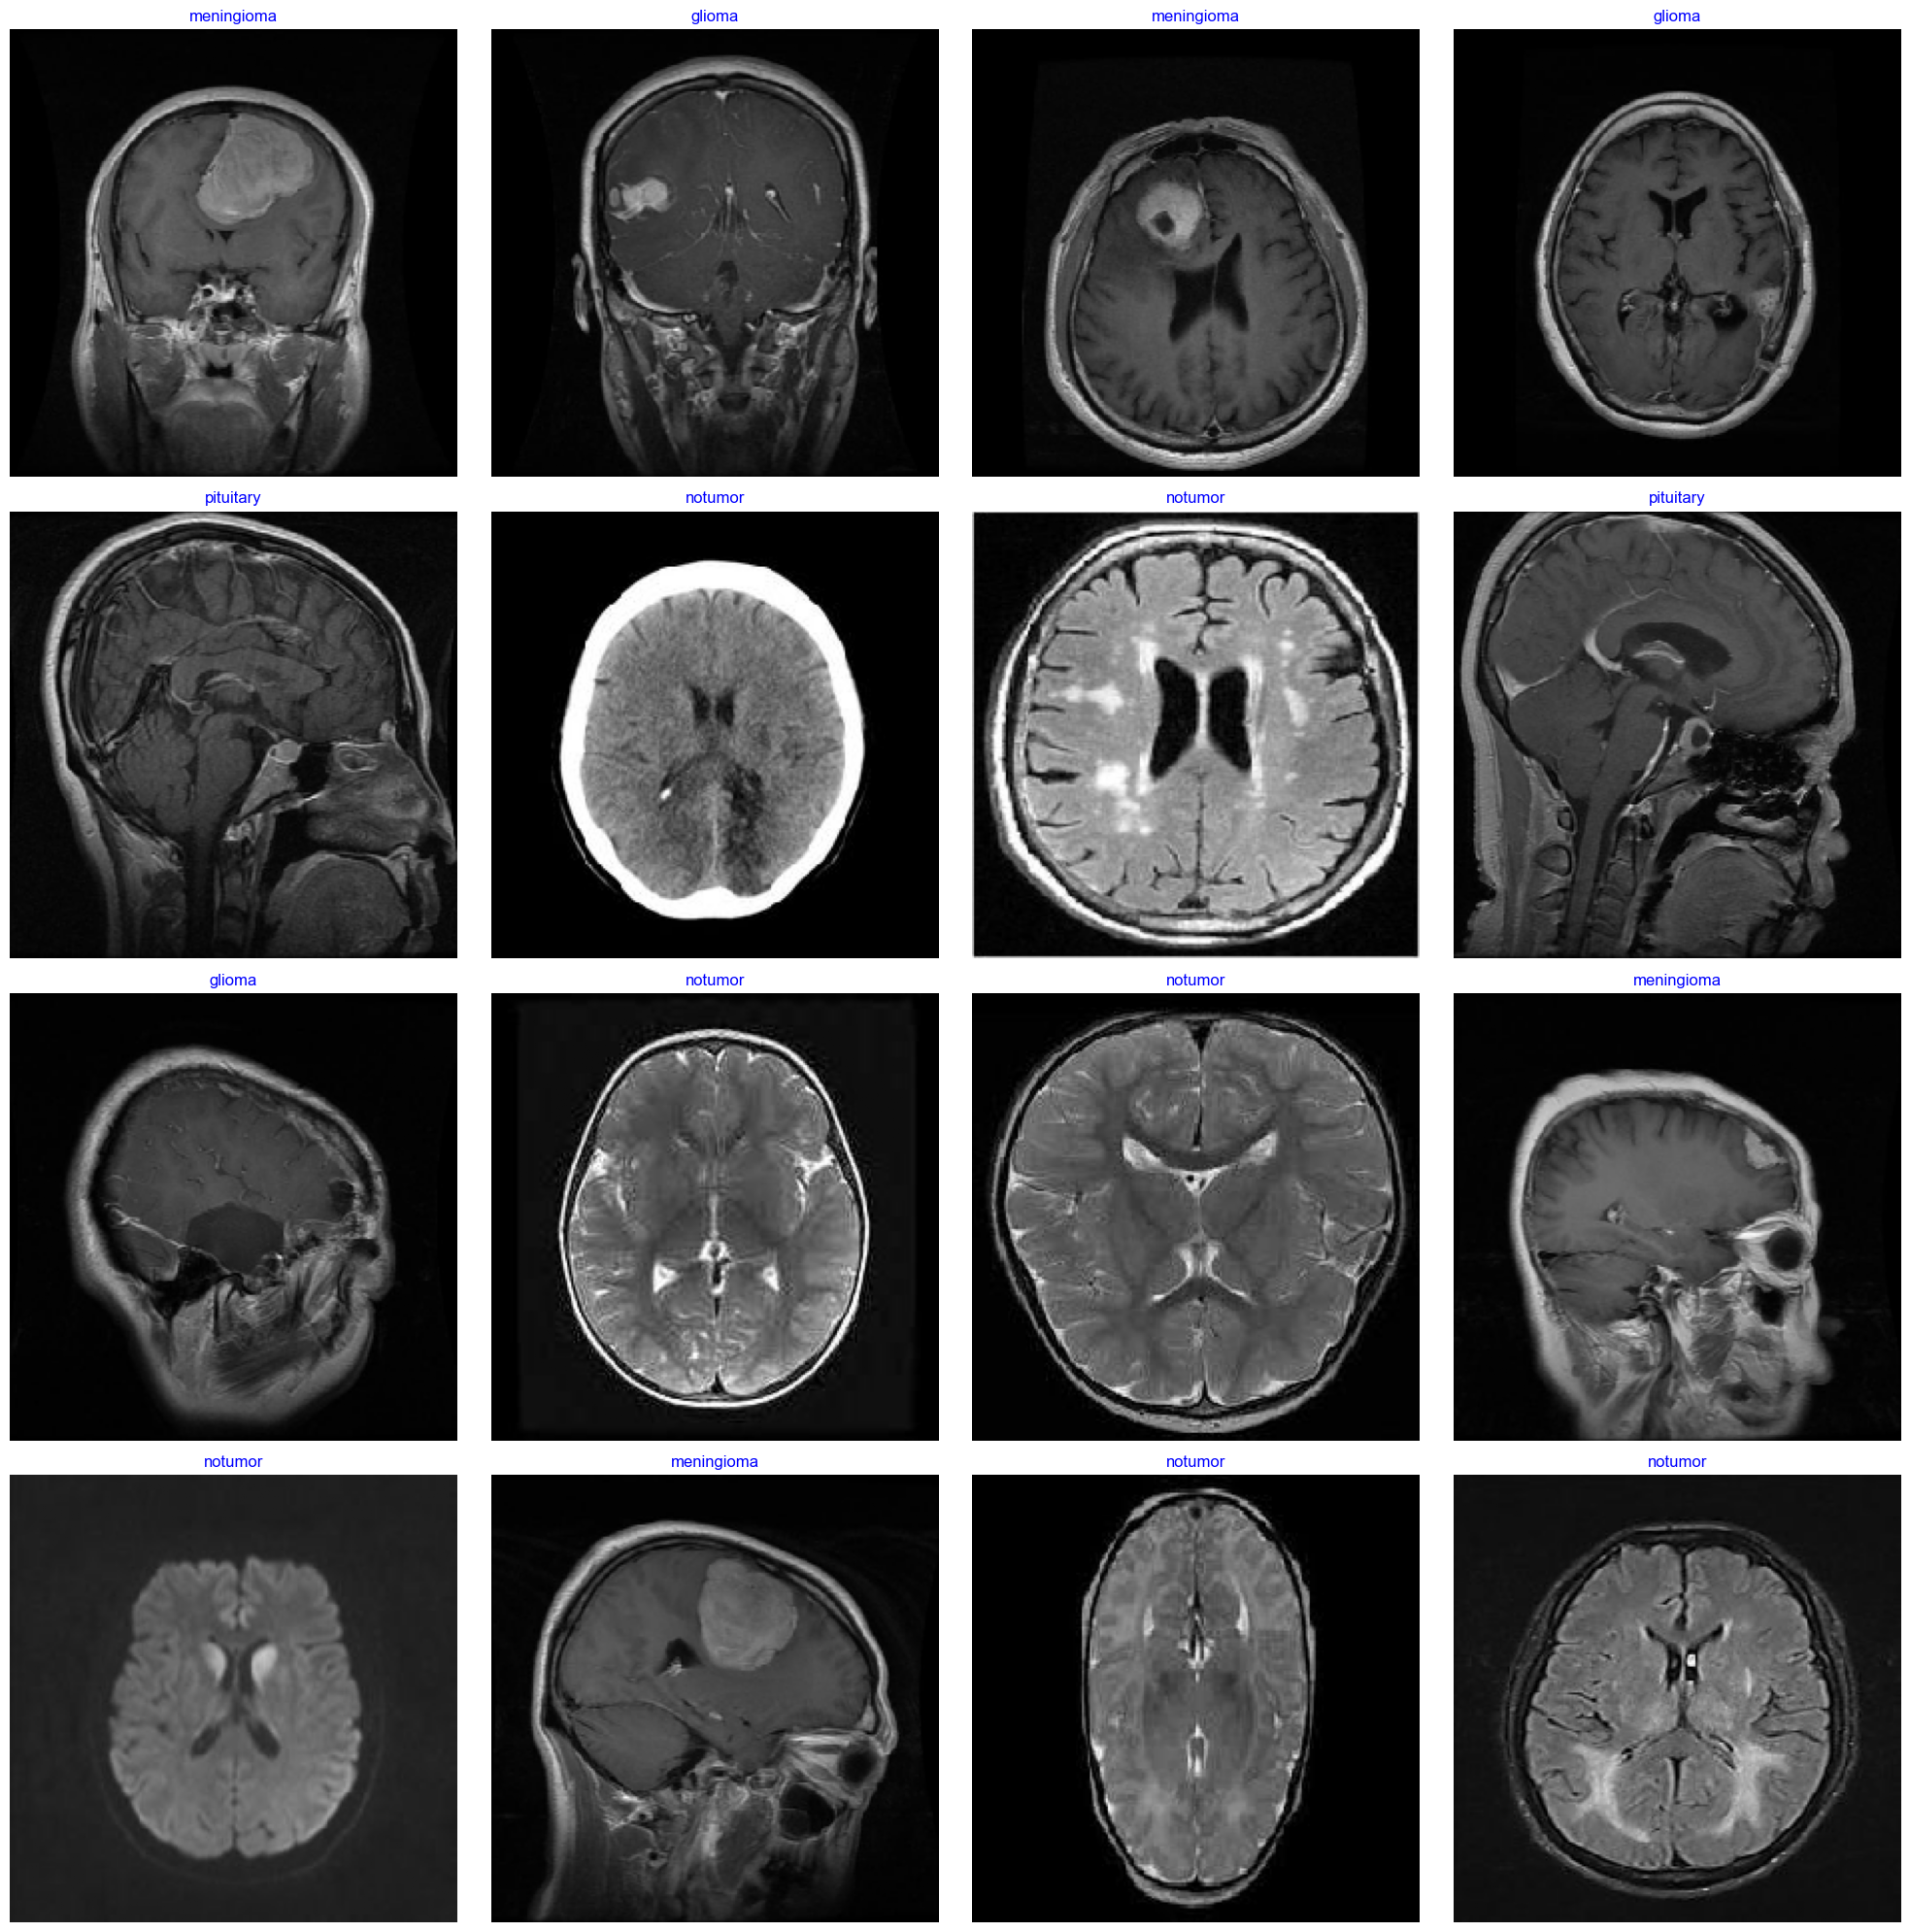

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Create Model Structure using EfficientNetB3
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
    input_tensor=None, input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.build(input_shape=(None, *img_shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [12]:
epochs = 20   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 590s 7s/step - accuracy: 0.4953 - loss: 5.3916 - val_accuracy: 0.6153 - val_loss: 5.0247
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 611s 7s/step - accuracy: 0.5711 - loss: 4.8980 - val_accuracy: 0.6534 - val_loss: 4.5322
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 627s 8s/step - accuracy: 0.5737 - loss: 4.4578 - val_accuracy: 0.6382 - val_loss: 4.0927
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.6021 - loss: 4.0181 - val_accuracy: 0.6046 - val_loss: 3.7386
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 643s 8s/step - accuracy: 0.5572 - loss: 3.6959 - val_accuracy: 0.6427 - val_loss: 3.4146
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 591s 7s/step - accuracy: 0.6103 - loss: 3.3530 - val_accuracy: 0.6458 - val_loss: 3.1073
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 610s 7s/step - accuracy: 0.5743 - loss: 3.0595 - val_accuracy: 0.6840 - val_loss: 2.8159
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 734s 9s/step - accuracy: 0.6064 - loss: 2.7788 - val_accuracy: 0.7084 - v

In [13]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss') 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

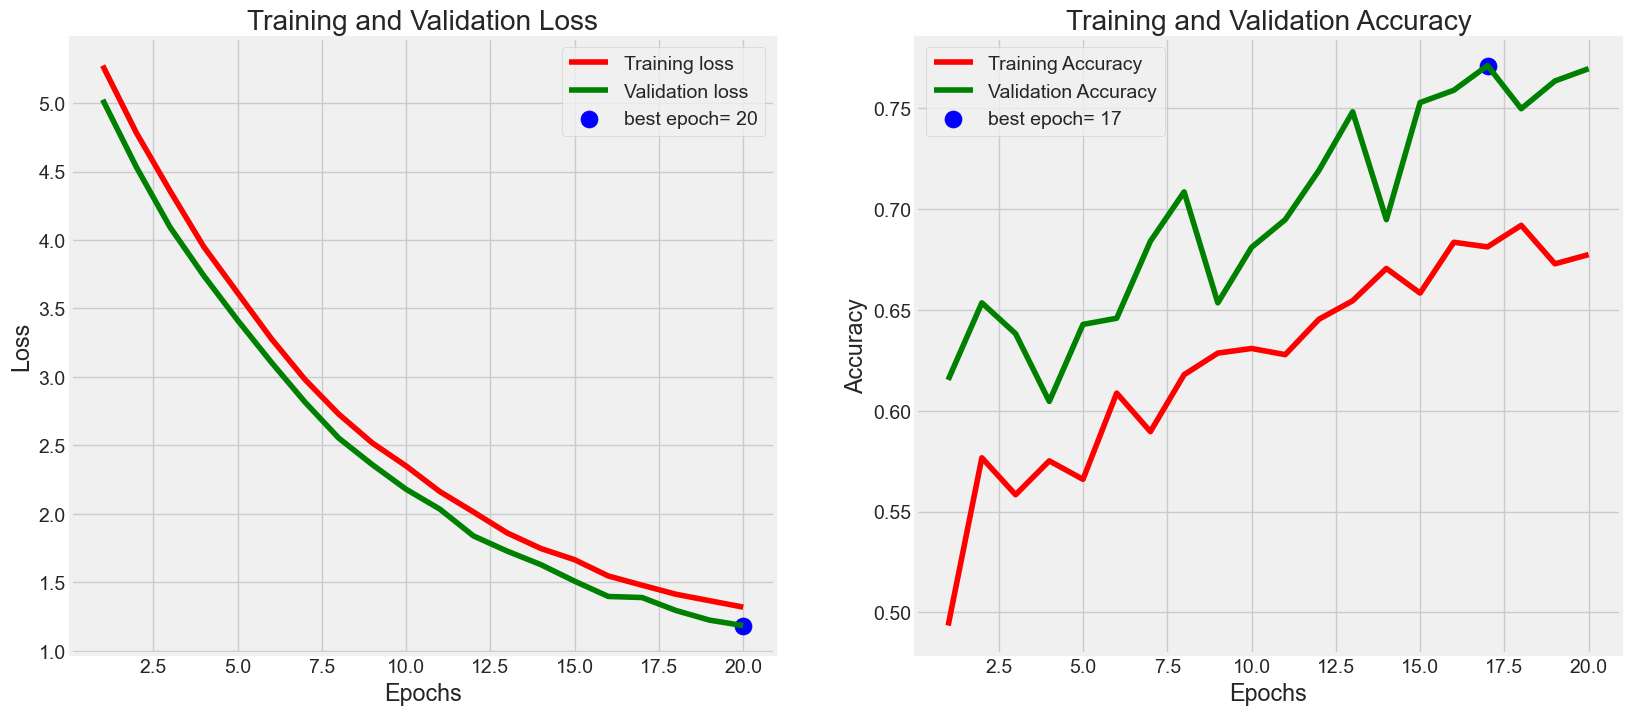

In [14]:
plot_training(history)

In [15]:
#model evaluation
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 882ms/step - accuracy: 0.7570 - loss: 1.1883
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 888ms/step - accuracy: 0.7694 - loss: 1.1928
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 952ms/step - accuracy: 0.7358 - loss: 1.2200
Train Loss:  1.1861485242843628
Train Accuracy:  0.7627764940261841
--------------------
Validation Loss:  1.1829828023910522
Validation Accuracy:  0.7694656252861023
--------------------
Test Loss:  1.1892118453979492
Test Accuracy:  0.7560975551605225


In [16]:
preds = model.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 829ms/step


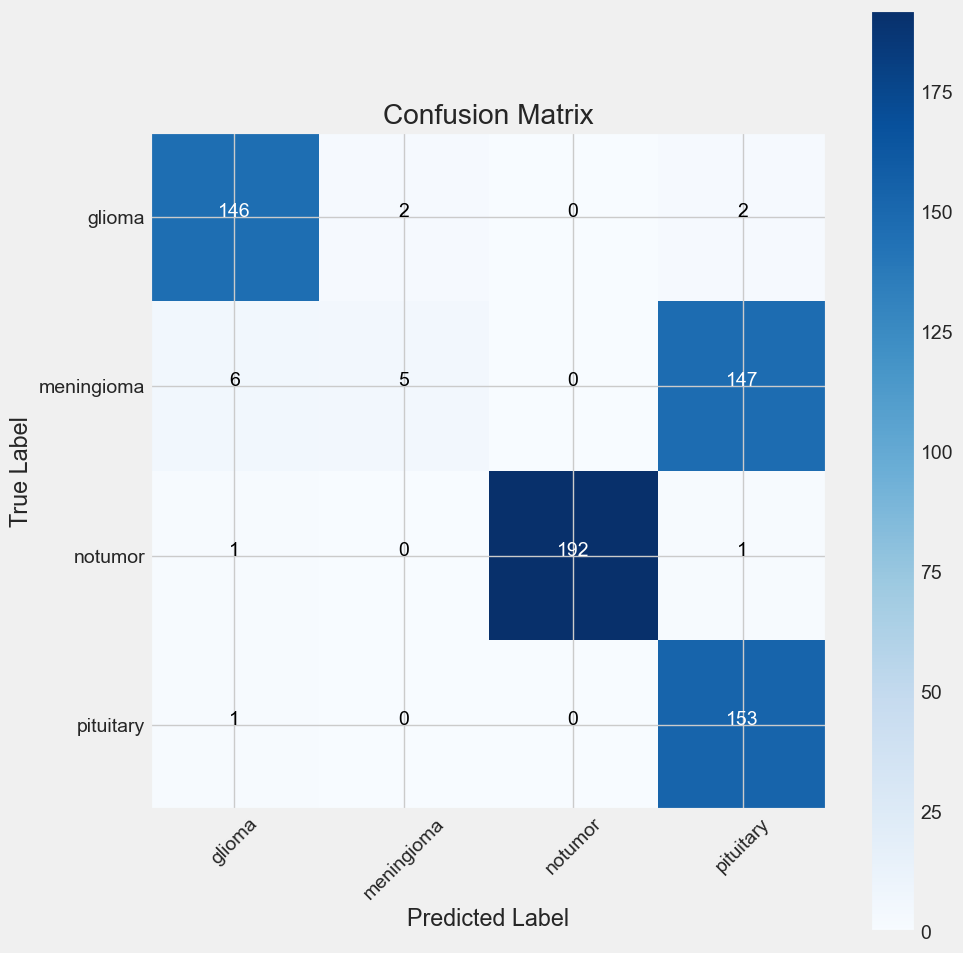

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
# Unfreeze some of the deeper layers for fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adamax(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary after unfreezing
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [21]:
# Fine-tune the model with the unfrozen layers
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history_fine = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7230 - loss: 1.2294
Epoch 1: val_loss improved from inf to 1.12788, saving model to best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 659s 7s/step - accuracy: 0.7229 - loss: 1.2293 - val_accuracy: 0.7725 - val_loss: 1.1279
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6980 - loss: 1.2292
Epoch 2: val_loss improved from 1.12788 to 1.11625, saving model to best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 558s 7s/step - accuracy: 0.6979 - loss: 1.2291 - val_accuracy: 0.7649 - val_loss: 1.1162
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7300 - loss: 1.1889
Epoch 3: val_loss improved from 1.11625 to 1.11387, saving model to best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 602s 7s/step - accuracy: 0.7297 - loss: 1.1892 - val_accuracy: 0.7588 - val_loss: 1.1139
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7094 - loss: 1.2036 
Epoch 4: val_loss improved from 1.11387 to 1.10464, saving model to

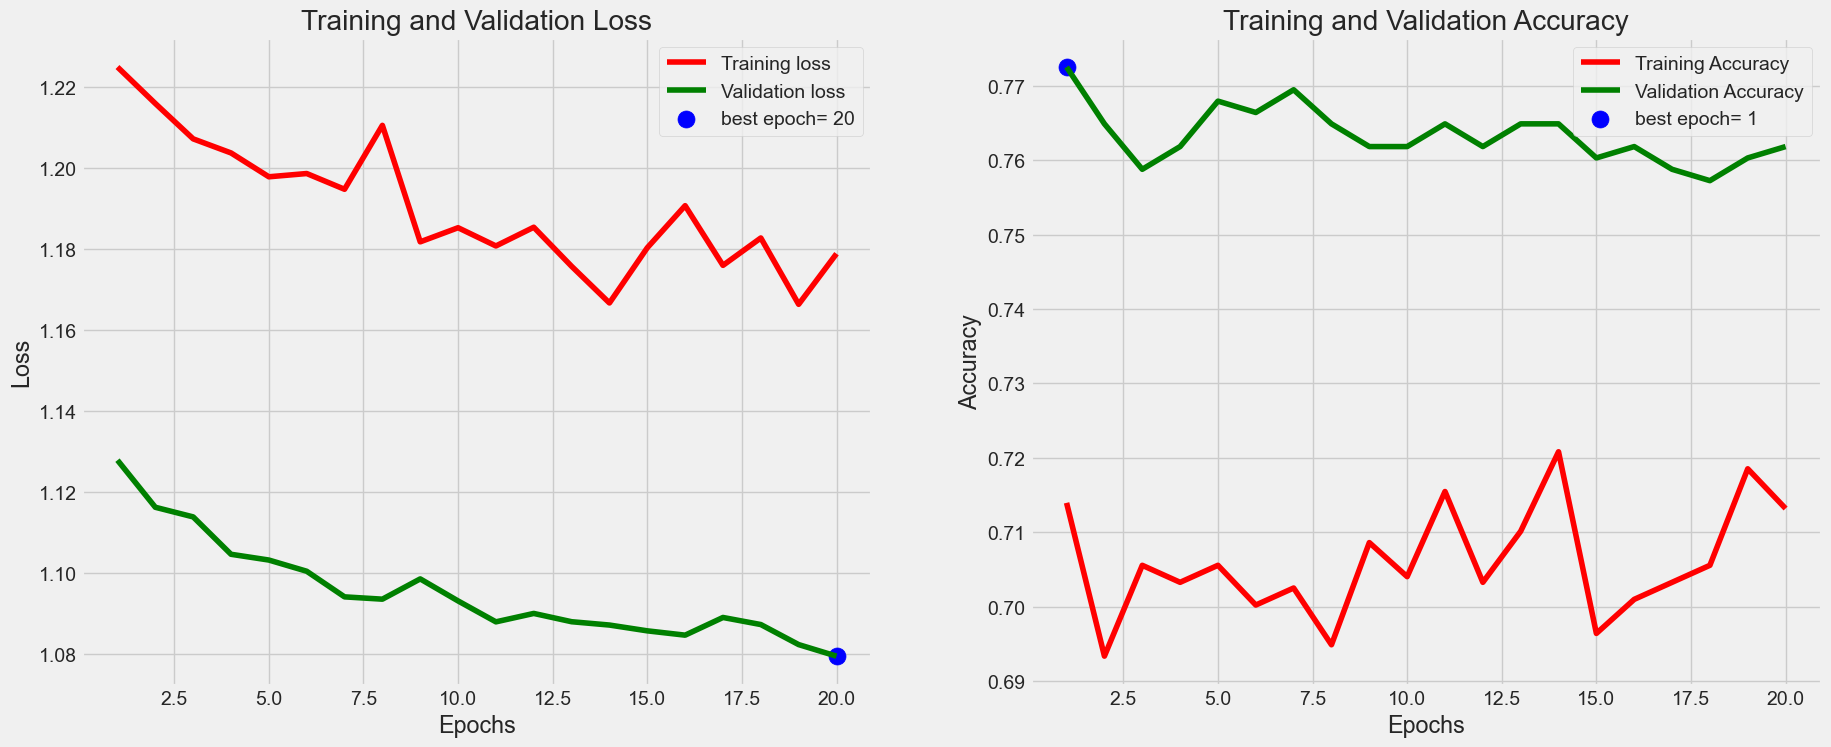

In [22]:
plot_training(history_fine)

In [23]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 945ms/step - accuracy: 0.7448 - loss: 1.1038
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7581 - loss: 1.0702 
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 955ms/step - accuracy: 0.7029 - loss: 1.1557
Train Loss:  1.0956884622573853
Train Accuracy:  0.75390625
--------------------
Validation Loss:  1.0842580795288086
Validation Accuracy:  0.7578125
--------------------
Test Loss:  1.129555344581604
Test Accuracy:  0.734375


41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 999ms/step


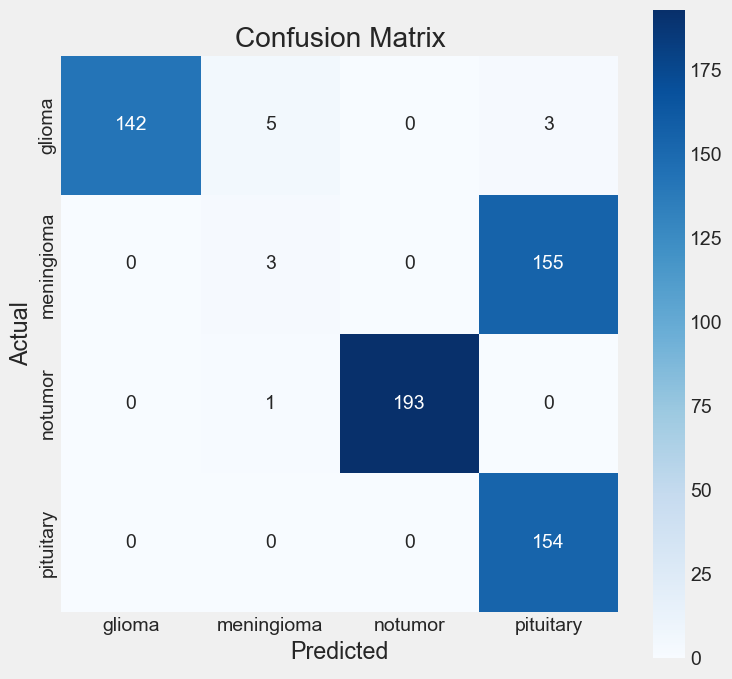

In [24]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# # Plot confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()